In [1]:
import numpy as np
import string
import nltk
from collections import defaultdict
from nltk.corpus import brown
import time
from sklearn_crfsuite import CRF

In [2]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/amanrishalch/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/amanrishalch/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:

brown_words = brown.words()
brown_tags = [tag for word, tag in brown.tagged_words(tagset='universal')]
tokens = list(set(brown_words))
tags = ["START"] + list(set(brown_tags))
n_tags = len(tags)
token_to_index = {token: i for i, token in enumerate(tokens)}
tag_to_index = {tag: i for i, tag in enumerate(tags)}


In [4]:

tm = np.zeros((n_tags, n_tags))
em = np.zeros((n_tags, len(tokens)))

def training(dataset):
    transition_freq = defaultdict(int)
    emission_freq = defaultdict(int)
    tag_freq = defaultdict(int)

    for sent in dataset:
        prev_tag = "START"
        for tup in sent:
            transition_freq[(prev_tag, tup[1])] += 1
            emission_freq[(tup[1], tup[0])] += 1
            tag_freq[tup[1]] += 1
            prev_tag = tup[1]

    # Smoothing parameter
    a = 1e-8

    # Calculate transition and emission probabilities
    for i, tag_i in enumerate(tags):
        for j, tag_j in enumerate(tags):
            transition_count = transition_freq[(tag_i, tag_j)] + a
            transition_total = tag_freq[tag_i] + a * n_tags
            tm[i][j] = transition_count / transition_total

        for k, token in enumerate(tokens):
            emission_count = emission_freq[(tag_i, token)] + a
            emission_total = tag_freq[tag_i] + a * len(tokens)
            em[i][k] = emission_count / emission_total

    return tm, em

In [6]:
def preprocess_sent(sent):
    # Convert to lowercase and split into words
    return [word for word in sent.split()]

def Viterbi_decoder(t_mat, e_mat, sent):
    words = preprocess_sent(sent)
    n = len(words)
    prob_mat = np.zeros((n, n_tags))
    tag_mat = np.zeros((n, n_tags), dtype=int)

    # Initialize the first column of the probability matrix
    first_word_index = token_to_index.get(words[0], -1)

    # Correctly initialize probabilities for the first word
    for i in range(n_tags):
        prob_mat[0][i] = t_mat[tag_to_index["START"]][i] * (e_mat[i][first_word_index] if first_word_index != -1 else 1e-10)

    # Fill the probability and tag matrices
    for s in range(1, n):
        curr_token = words[s]
        curr_token_index = token_to_index.get(curr_token, -1)

        for t in range(n_tags):
            max_prob, prev_tag_index = max(
                (prob_mat[s-1][u] * t_mat[u][t], u) for u in range(n_tags)
            )
            prob_mat[s][t] = max_prob * (e_mat[t][curr_token_index] if curr_token_index != -1 else 1e-10)
            tag_mat[s][t] = prev_tag_index

    # Backtrack to find the best path
    pred = []
    last_tag = np.argmax(prob_mat[-1])
    pred.append(tags[last_tag])

    for i in range(n - 1, 0, -1):
        last_tag = tag_mat[i][last_tag]
        pred.append(tags[last_tag])

    pred.reverse()
    return words, pred

def sent2features(sent):
    features = []
    for i, word in enumerate(sent):
        feature = {
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],
            'word[-2:]': word[-2:],
            'word.isupper()': word.isupper(),
            'word.istitle()': word.istitle(),
            'word.isdigit()': word.isdigit(),
        }
        if i > 0:
            feature['prev_word.lower()'] = sent[i - 1].lower()
        else:
            feature['BOS'] = True  # Beginning of sentence
        if i < len(sent) - 1:
            feature['next_word.lower()'] = sent[i + 1].lower()
        else:
            feature['EOS'] = True  # End of sentence
        features.append(feature)
    return features


In [23]:
# Initialize and train the CRF model with optimizations
def train_crf_model(tagged_sents, max_iter=100):  # Reduce max iterations for faster training
    crf_model = CRF(algorithm='lbfgs',c1=0.1, c2=0.1, max_iterations=max_iter, all_possible_transitions=True)  # Enable all possible transitions for better performance
    X_train = []
    y_train = []

    # Limit to a smaller subset for quicker training during development
    subset_size = len(tagged_sents)  # Adjust this number as needed for speed
    for sent in tagged_sents[:subset_size]:  # Use a smaller subset of the dataset
        features = sent2features(preprocess_sent(' '.join([word for word, _ in sent])))
        X_train.append(features)
        y_train.append([tag for _, tag in sent])

    crf_model.fit(X_train, y_train)
    return crf_model

# Training on Brown Corpus
tagged_sents = brown.tagged_sents(tagset='universal')
training(tagged_sents)
crf_model = train_crf_model(tagged_sents)


In [30]:

# Input sentence for testing
# sent = input("Enter a sentence: ")
sent = "why did the Indian cry"

In [31]:
# Timing and prediction with HMM
hmm_start = time.perf_counter()  # Use perf_counter for better precision
output_hmm = Viterbi_decoder(tm, em, sent)
hmm_end = time.perf_counter()

# Timing for CRF
crf_start = time.perf_counter()
sent_features = sent2features(preprocess_sent(sent))
crf_output = crf_model.predict([sent_features])[0]  # Using the trained CRF model
crf_end = time.perf_counter()

# Display results
# print("Words:", output_hmm[0])
# print("HMM Tags:", output_hmm[1])
# print("CRF Tags:", crf_output)
print(f"HMM Prediction Time: {hmm_end - hmm_start:.4f} seconds")
print(f"CRF Prediction Time: {crf_end - crf_start:.4f} seconds")

import pandas as pd
df = pd.DataFrame({'words': output_hmm[0],'hmm': output_hmm[1], 'crf': crf_output})
print(df)

HMM Prediction Time: 0.0005 seconds
CRF Prediction Time: 0.0002 seconds
    words   hmm   crf
0     why   ADV   ADV
1     did  VERB  VERB
2     the   DET   DET
3  Indian   ADJ   ADJ
4     cry  NOUN  NOUN


Evaluating HMM Model...
HMM Model Accuracy: 0.9508

HMM Model Classification Report:
              precision    recall  f1-score   support

         PRT     0.8976    0.9151    0.9063      5853
        NOUN     0.9631    0.9380    0.9504     54822
        PRON     0.9518    0.9839    0.9676      9934
        VERB     0.9733    0.9343    0.9534     36744
        CONJ     0.9934    0.9922    0.9928      7529
           X     0.6970    0.3495    0.4656       329
         ADJ     0.9186    0.8994    0.9089     16772
         ADP     0.9525    0.9630    0.9577     28768
         DET     0.9626    0.9862    0.9742     27474
         NUM     0.9752    0.9052    0.9389      2911
           .     0.9958    0.9981    0.9970     29520
         ADV     0.8829    0.8940    0.8884     11271

   micro avg     0.9591    0.9508    0.9549    231927
   macro avg     0.9303    0.8966    0.9084    231927
weighted avg     0.9590    0.9508    0.9547    231927



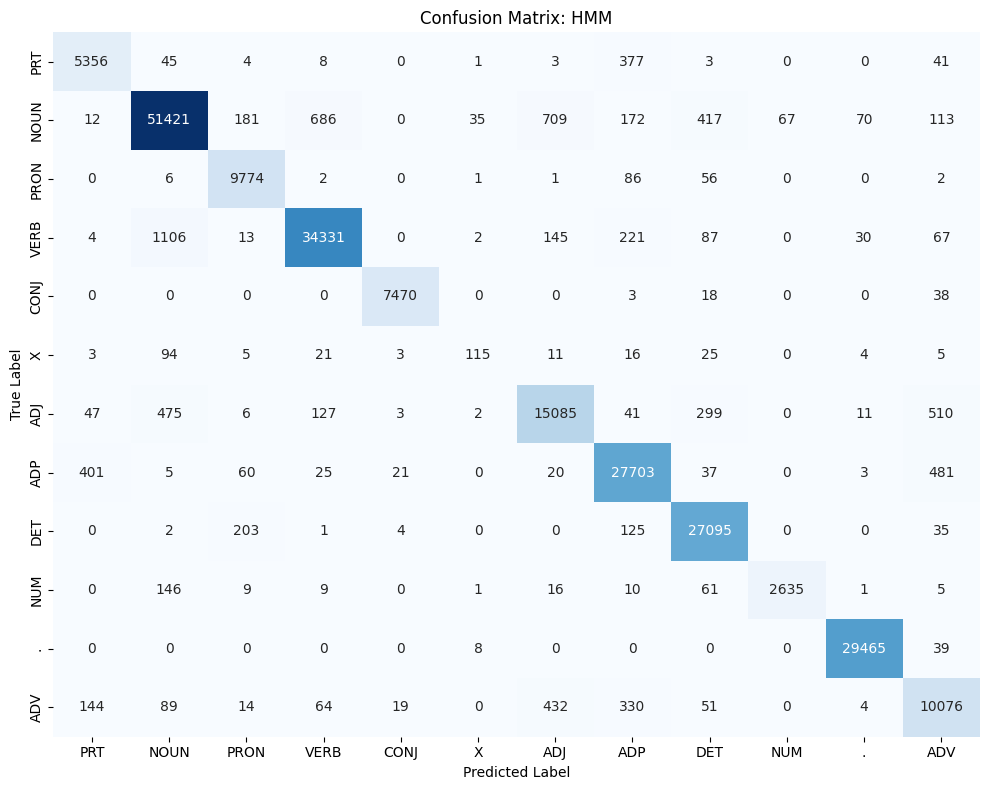


Evaluating CRF Model...
CRF Model Accuracy: 0.9780

CRF Model Classification Report:
              precision    recall  f1-score   support

         PRT     0.9463    0.9395    0.9429      5853
        NOUN     0.9730    0.9803    0.9767     54822
        PRON     0.9907    0.9888    0.9898      9934
        VERB     0.9770    0.9794    0.9782     36744
        CONJ     0.9950    0.9965    0.9958      7529
           X     0.8581    0.4043    0.5496       329
         ADJ     0.9437    0.9307    0.9372     16772
         ADP     0.9780    0.9845    0.9812     28768
         DET     0.9946    0.9942    0.9944     27474
         NUM     0.9843    0.9674    0.9757      2911
           .     0.9998    1.0000    0.9999     29520
         ADV     0.9520    0.9365    0.9442     11271

    accuracy                         0.9780    231927
   macro avg     0.9660    0.9252    0.9388    231927
weighted avg     0.9779    0.9780    0.9778    231927



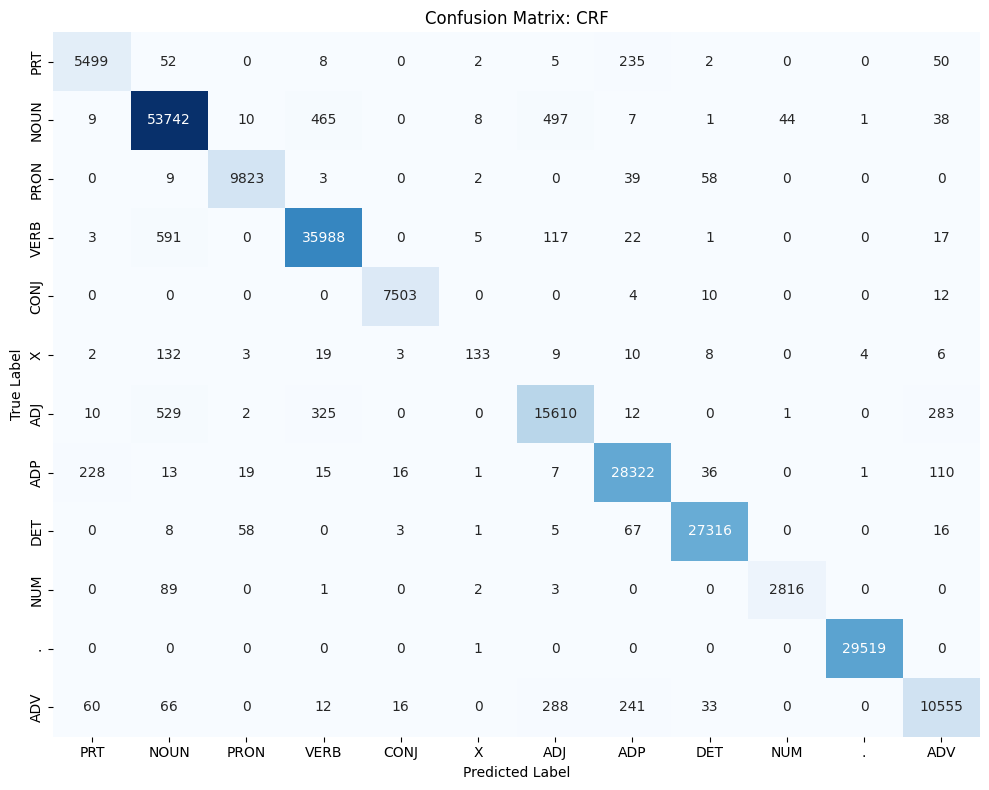


===== Final Comparison =====
HMM Model Accuracy: 0.9508
CRF Model Accuracy: 0.9780


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Function to save classification report to file
def save_classification_report(report, filename):
    with open(filename, 'w') as f:
        f.write(report)
    f.close()

# Function to plot and save confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, title, filename):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix: {title}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Split the Brown Corpus into training and test sets
tagged_sents = brown.tagged_sents(tagset='universal')
train_sents, test_sents = train_test_split(tagged_sents, test_size=0.2, random_state=42)

# Build the tokens and tags from the training set
brown_words = [word for sent in train_sents for word, tag in sent]
brown_tags = [tag for sent in train_sents for word, tag in sent]
tokens = list(set(brown_words))
tags = ["START"] + list(set(brown_tags))  # Add "START" and unique tags
n_tags = len(tags)
token_to_index = {token: i for i, token in enumerate(tokens)}
tag_to_index = {tag: i for i, tag in enumerate(tags)}

# Re-initialize transition and emission matrices with new tokens and tags
tm = np.zeros((n_tags, n_tags))
em = np.zeros((n_tags, len(tokens)))

# Train the HMM model
tm, em = training(train_sents)

# Train the CRF model
crf_model = train_crf_model(train_sents)

# Function to evaluate HMM model accuracy and per-tag accuracy
def evaluate_hmm(test_sents):
    total_words = 0
    correct_predictions = 0
    y_true = []
    y_pred = []

    for sent in test_sents:
        words = [word for word, _ in sent]
        true_tags = [tag for _, tag in sent]

        _, pred_tags = Viterbi_decoder(tm, em, ' '.join(words))

        # Update total words and count correct predictions
        total_words += len(true_tags)
        correct_predictions += sum(1 for true_tag, pred_tag in zip(true_tags, pred_tags) if true_tag == pred_tag)

        y_true.extend(true_tags)
        y_pred.extend(pred_tags)

    # Calculate overall accuracy
    hmm_accuracy = correct_predictions / total_words
    print(f"HMM Model Accuracy: {hmm_accuracy:.4f}")

    # Generate classification report
    report = classification_report(y_true, y_pred, labels=list(set(y_true)), digits=4)
    print("\nHMM Model Classification Report:")
    print(report)

    # Save the report to a file
    save_classification_report(report, "hmm_classification_report.txt")

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, labels=list(set(y_true)), title="HMM", filename="hmm_confusion_matrix.png")

    return hmm_accuracy

# Function to evaluate CRF model accuracy and per-tag accuracy
def evaluate_crf(test_sents):
    X_test = []
    y_test = []

    for sent in test_sents:
        words = [word for word, _ in sent]
        features = sent2features(words)
        X_test.append(features)
        y_test.append([tag for _, tag in sent])

    # Predict tags using the CRF model
    crf_predictions = crf_model.predict(X_test)

    # Flatten true and predicted tags
    y_test_flat = [tag for sent_tags in y_test for tag in sent_tags]
    crf_predictions_flat = [tag for sent_tags in crf_predictions for tag in sent_tags]

    # Calculate overall accuracy
    crf_accuracy = accuracy_score(y_test_flat, crf_predictions_flat)
    print(f"CRF Model Accuracy: {crf_accuracy:.4f}")

    # Generate classification report
    report = classification_report(y_test_flat, crf_predictions_flat, labels=list(set(y_test_flat)), digits=4)
    print("\nCRF Model Classification Report:")
    print(report)

    # Save the report to a file
    save_classification_report(report, "crf_classification_report.txt")

    # Plot confusion matrix
    plot_confusion_matrix(y_test_flat, crf_predictions_flat, labels=list(set(y_test_flat)), title="CRF", filename="crf_confusion_matrix.png")

    return crf_accuracy

# Evaluate both models
print("Evaluating HMM Model...")
hmm_accuracy = evaluate_hmm(test_sents)

print("\nEvaluating CRF Model...")
crf_accuracy = evaluate_crf(test_sents)

# Final comparison report
print("\n===== Final Comparison =====")
print(f"HMM Model Accuracy: {hmm_accuracy:.4f}")
print(f"CRF Model Accuracy: {crf_accuracy:.4f}")


In [37]:
import pickle

# Save transition and emission matrices using pickle
with open('hmm_model.pkl', 'wb') as f:
    pickle.dump({
        'transition_matrix': tm,
        'emission_matrix': em,
        'token_to_index': token_to_index,
        'tag_to_index': tag_to_index
    }, f)
with open('crf_model.pkl', 'wb') as f:
    pickle.dump(crf_model, f)